In [387]:
#%matplotlib notebook
import sys
import os
#messi
# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import project                # to fit an rpc
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read SkySat images and RPCs

In [388]:
import glob

# load images from folder and rpcs from TXT
exp_name = 'skysat_scene/tristereo-sample-morenci'
input_dir = os.path.join('ba_experiments/',exp_name)

# read tiff images 
myimages = np.sort(glob.glob(input_dir+'/frames/*.tif'))
myimages = myimages[:10]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })
#vistools.display_gallery(mycrops)

# load RPC coefficients
os.chdir('../s2p/')
from s2plib import rpc_model
#myrpcs2 = [rpc_model.RPCModel('../IS18/'+os.path.splitext(im)[0]+'_rpc.txt') for im in myimages]
myrpcs2 = [rpc_model.RPCModel('../IS18/'+os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
print('Finished loading RPC coefficients')
os.chdir('../IS18/')

Found 6 images
Number of images to be used: 6
Finished loading RPC coefficients


### Approximate RPCs as projection matrices

In [389]:
# approximate rpcs as a as projective matrices

os.chdir('../s2p/')
from s2plib import rpc_utils
cam_model = 'Perspective'
P_crop = []
for rpc2, crop in zip(myrpcs2, mycrops):
    x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
    P_img = rpc_utils.approximate_rpc_as_projective(rpc2, [x,x+w,10], [y,y+h,10], \
                                                    [rpc2.altOff - 100, rpc2.altOff + 100, 10], verbose=False)
    P_crop.append(P_img/P_img[2,3])
print('RPCs successfully approximated as projection matrices')
os.chdir('../IS18/')

RPCs successfully approximated as projection matrices


### Detect feature tracks

In [390]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2

#FEATURE TRACKS REPRESENTATION
#feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
#r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

def build_tracks_optimized(mycrops):

    print('Starting feature track detection...\n')

    # (1) detect SIFT keypoints in all images
    features = []
    cont = 0
    reduce_kp, max_kp_per_im = False, 7000  
    for f in range(len(mycrops)):
        kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
        if len(kp) > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(len(kp))
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        features.append({ 'kp': kp, 'des': des })
        print('Found', len(kp), 'keypoints in image', cont)
        cont += 1
        #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
        #vistools.display_image(im_kp)

    print('\n')

    #(2) pairs with extremly short baselines are not well posed for depth from stereo so we filter them
    pairs_to_match = []
    for i in range(n_cam):
        for j in range(i+1,n_cam):
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
            _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
            
            baseline_thr = 150000 # esto deberian ser un poco más de la distancia recorrida en medio segundo (en m ?)
                                  # no me cuadra mucho con la supuesta speed de skysat de 7 km/s (~3500 m en medio s)
            
            if np.linalg.norm(optical_center2 - optical_center1) > baseline_thr :
                pairs_to_match.append([i,j])
    
    # (3) create feature tracks
    tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
    for [i,j] in pairs_to_match:
        kp_i, des_i = features[i]['kp'], features[i]['des']
        kp_j, des_j = features[j]['kp'], features[j]['des']
        pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
        n_matches = 0 if pts_i is None else pts_i.shape[0]
        print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

        # display matches for pair (i,j)
        #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
        #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

        if pts_i is not None:
            pts_i_tuples = [tuple(pair) for pair in pts_i.tolist()]
            pts_i_dict = {pair:i for i, pair in enumerate(pts_i_tuples)}

            pts_i_track = [tuple(pair) for pair in feature_tracks[:,:,i].tolist()]
            pts_i_track_dict = {pair:i for i, pair in enumerate(pts_i_track)}

            intersect = np.array([[pts_i_dict[k], pts_i_track_dict[k]] for k in pts_i_dict.keys()&pts_i_track_dict.keys()])
            # attention: the meaning/interst of 'intersect' is not trivial
            # each value in 'idx_pts_i' is the index of an observation X from 'pts_i', while each corresponding
            # value in 'idx_existing_tracks' is the index of the track that contains the observation X 
            if intersect.shape[0] > 0:
                idx_pts_i, idx_existing_tracks = intersect[:,0], intersect[:,1]
                # extend existing tracks by adding the coords of observation X in image j from pts_j
                feature_tracks[idx_existing_tracks,:,j] = pts_j[idx_pts_i,:]
                r[idx_existing_tracks,i], r[idx_existing_tracks,j] = 1, 1

            # list of points in 'pts_i' that do not correspond to any previous feature track
            new_pts_from_i = list(set(pts_i_dict) - set(pts_i_track_dict))
            if len(new_pts_from_i) > 0:
                new_pts_from_j = [tuple(pts_j[pts_i_dict[k],:]) for k in new_pts_from_i]
                new_tracks = np.zeros((len(new_pts_from_i),2,n_cam))
                new_tracks[:,:,i], new_tracks[:,:,j]  = np.array(new_pts_from_i), np.array(new_pts_from_j)
                new_r = np.zeros((len(new_pts_from_i),n_cam))
                new_r[:,i], new_r[:,j] = 1, 1
                feature_tracks, r = np.vstack((feature_tracks, new_tracks)), np.vstack((r, new_r))
            
    feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
    return feature_tracks, r

#from timeit import Timer
#timer = Timer(lambda: build_tracks_optimized(mycrops))
#elapsed_time = timer.timeit(number=1)
#hours, rem = divmod(elapsed_time, 3600)
#minutes, seconds = divmod(rem, 60)
#print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

feature_tracks, r = build_tracks_optimized(mycrops)

# build correspondence matrix
C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)

n_complete_tracks = np.sum(1*(~(np.sum((C!=C).astype(int), 0)).astype(bool)))
print('\nFound {} feature tracks, {} of them complete'.format(C.shape[1], n_complete_tracks))

import pickle

pickle_out = open(input_dir+'/features.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')

Starting feature track detection...

Found 44181 keypoints in image 0
Found 39711 keypoints in image 1
Found 45947 keypoints in image 2
Found 36496 keypoints in image 3
Found 46340 keypoints in image 4
Found 32398 keypoints in image 5


Pair (0,2) -> 3057 matches preserved out of 44181
Pair (0,3) -> 241 matches preserved out of 44181
Pair (0,4) -> 318 matches preserved out of 44181
Pair (0,5) -> 56 matches preserved out of 44181
Pair (1,2) -> 768 matches preserved out of 39711
Pair (1,3) -> 4093 matches preserved out of 39711
Pair (1,4) -> 113 matches preserved out of 39711
Pair (1,5) -> 556 matches preserved out of 39711
Pair (2,4) -> 3425 matches preserved out of 45947
Pair (2,5) -> 868 matches preserved out of 45947
Pair (3,4) -> 284 matches preserved out of 36496
Pair (3,5) -> 2715 matches preserved out of 36496

Found 12546 feature tracks, 0 of them complete

Correspondence matrix saved!


Load feature tracks:

In [391]:
import pickle

pickle_in = open(input_dir+'/features.pickle','rb')
C = pickle.load(pickle_in)
print('Correspondence matrix loaded!')

Correspondence matrix loaded!


Remove incomplete tracks if wanted:

In [392]:
# invert coords of the tracks (necessary when dealing with the preliminary camera model of skysat)
#C2 = np.zeros(C.shape)
#C2[::2,:] = C[1::2,:]
#C2[1::2,:] = C[::2, :]
#C = C2.copy()

# select a random subset of 1000 obs
#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (1000,), replace=False)
#C = C[:,idx_to_preserve]

#C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

print('Only complete feature tracks were preserved: {} in total'. format(C.shape[1]))

Only complete feature tracks were preserved: 12546 in total


### Initialize 3D points for Bundle Adjustment

In [393]:
print('Initializing 3D points...')

pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('...done!\n')

print(pts_3d)

Initializing 3D points...
...done!

[[-1771951.07760544 -5045968.98842082  3467158.13407267]
 [-1772300.21970945 -5045719.10205657  3467097.50212091]
 [-1771766.64258507 -5046255.17876042  3466977.34430756]
 ...
 [-1772007.29088281 -5046441.36950571  3466598.56449986]
 [-1772450.34214195 -5045831.83438251  3466835.09898846]
 [-1772634.07464023 -5045818.79043268  3466676.41981631]]


### Define Bundle Adjustment parameters

In [394]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

print('Defining BA input parameters...')

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

print('...done!\n')

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{} cam_params_opt.shape:{}\n'.format(pts_3d.shape, cam_params.shape, cam_params_opt.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

Defining BA input parameters...
...done!

pts_2d.shape:(27547, 2)  pts_ind.shape:(27547,)  cam_ind.shape:(27547,)
pts_3d.shape:(12546, 3)  cam_params.shape:(6, 11) cam_params_opt.shape:(6, 3)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run Bundle Adjustment (soft L1 loss)

Shape of matrix A: 55094x37656
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5899e+04                                    1.93e+10    
       1              6         2.0653e+04      5.25e+03       1.07e+03       1.25e+10    
       2              9         1.7030e+04      3.62e+03       2.00e+02       8.96e+09    
       3             11         1.6341e+04      6.89e+02       8.64e+01       7.90e+09    
       4             12         1.5853e+04      4.88e+02       2.45e+01       6.07e+09    
       5             13         1.5467e+04      3.85e+02       7.81e+01       3.46e+09    
       6             14         1.5300e+04      1.67e+02       1.77e+02       2.43e+09    
       7             15         1.5059e+04      2.42e+02       4.57e+01       2.22e+09    
       8             16         1.4874e+04      1.85e+02       9.37e+01       1.94e+09    
       9             18         1.4778e+04      9.65e+01   

      89             101        5.2080e+03      4.80e+02       3.28e+03       2.69e+08    
      90             102        5.1257e+03      8.24e+01       2.56e+03       1.03e+08    
      91             105        5.1231e+03      2.53e+00       1.75e+01       7.58e+07    
      92             106        5.1154e+03      7.74e+00       4.50e+00       2.38e+07    
      93             107        5.1122e+03      3.20e+00       4.50e+00       1.36e+07    
      94             108        5.1103e+03      1.91e+00       8.56e+00       1.60e+07    
      95             109        5.1090e+03      1.27e+00       6.74e+00       9.41e+06    
      96             110        5.1086e+03      3.77e-01       7.76e+00       2.37e+06    
`ftol` termination condition is satisfied.
Function evaluations 110, initial cost 2.5899e+04, final cost 5.1086e+03, first-order optimality 2.37e+06.
Optimization took 70 seconds


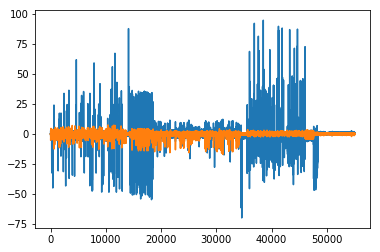

In [395]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

### Check reprojection error before and after Bundle Adjustment

Error before BA (mean / median): 2.27 / 0.79
Error after  BA (mean / median): 0.66 / 0.39


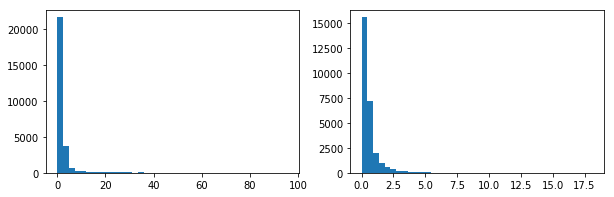

In [396]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40);
f[1].hist(ba_e, bins=40); 

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

 ----> Real 2D loc in im 0  (sol) =  [1898.582031 1022.731262]
 ----> Proj 2D loc in im 0  before BA =  [1898.63724174 1024.20943714]
 ----> Proj 2D loc in im 0  after  BA =  [1898.83554256 1023.07700222]
              Reprojection error beofre BA: 1.5333858741869335
              Reprojection error after  BA: 0.599251775325456
 ----> Real 2D loc in im 2  (sol) =  [1980.399048  780.202087]
 ----> Proj 2D loc in im 2  before BA =  [1978.21400874  779.40050873]
 ----> Proj 2D loc in im 2  after  BA =  [1979.870634    777.13019197]
              Reprojection error beofre BA: 2.986617526614282
              Reprojection error after  BA: 3.6003090271534575
 ----> Real 2D loc in im 4  (sol) =  [1879.620117  993.377869]
 ----> Proj 2D loc in im 4  before BA =  [1880.01161933  994.74502318]
 ----> Proj 2D loc in im 4  after  BA =  [1879.83158809  993.84300395]
              Reprojection error beofre BA: 1.7586565124084927
              Reprojection error after  BA: 0.6766060392083091

ECEF coo

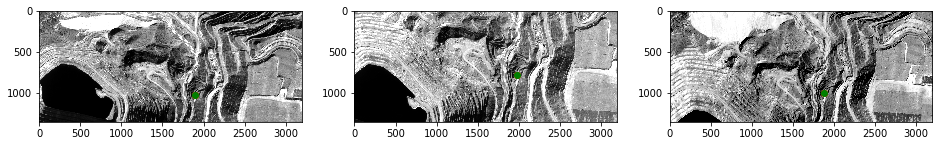

In [397]:
n_pts = C.shape[1]
#p_ind = pts_ind[np.argmax(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    #if cont == 0:
        #print('3D location (initial)  :', pts_3d[p_ind,:].ravel())
        #print('3D location (after BA) :', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    f[cont].imshow(mycrops[i]['crop'], cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    f[cont].plot(*p_2d_proj_ba, "go")
    
print('\nECEF coordinates of the 3D point:', pts_3d_ba[p_ind])

lat, lon, h = ba_utils.ecef_to_latlon_custom(x=pts_3d_ba[p_ind,0], y=pts_3d_ba[p_ind,1], z=pts_3d_ba[p_ind,2])
print('lat, lon: [{:.3f}, {:.3f}], alt: {:.3f}'.format(lat, lon, h))

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [398]:
lat, lon, alt = ba_utils.ecef_to_latlon_custom(pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2])

mymap = vistools.clickablemap(zoom=12)
## set the coordinates of the area of interest as a GeoJSON polygon
aoi = {'coordinates': [[[min(lon), min(lat)], [min(lon), max(lat)], 
                        [max(lon), max(lat)], [max(lon), min(lat)],
                        [min(lon), min(lat)]]], 'type': 'Polygon'}
# set the center of the aoi
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()
# display a polygon covering the aoi and center the map
mymap.add_GeoJSON(aoi) 
mymap.center = aoi['center'][::-1]
mymap.zoom = 15         
display(mymap)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

image 0, mean abs reproj error before BA: 1.6703
image 0, mean abs reproj error after  BA: 0.5970


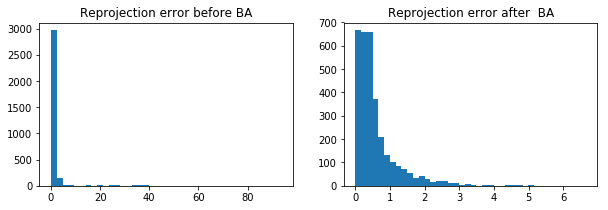

In [399]:
# set the index of the image to analyse
im_idx = 0

# pick all points visible in the selected image

pts_gt = C[(im_idx*2):(im_idx*2+2),~np.isnan(C[im_idx*2,:])].T
pts_3d_before = pts_3d[~np.isnan(C[im_idx*2,:]),:]
pts_3d_after = pts_3d_ba[~np.isnan(C[im_idx*2,:]),:]

# reprojections before bundle adjustment
proj = P_crop[im_idx] @ np.hstack((pts_3d_before, np.ones((pts_3d_before.shape[0],1)))).T
pts_reproj_before = (proj[:2,:]/proj[-1,:]).T

# reprojections after bundle adjustment
proj = P_crop_ba[im_idx] @ np.hstack((pts_3d_after, np.ones((pts_3d_after.shape[0],1)))).T
pts_reproj_after = (proj[:2,:]/proj[-1,:]).T

err_before = np.sum(abs(pts_reproj_before - pts_gt), axis=1)
err_after = np.sum(abs(pts_reproj_after - pts_gt), axis=1)

print('image {}, mean abs reproj error before BA: {:.4f}'.format(im_idx, np.mean(err_before)))
print('image {}, mean abs reproj error after  BA: {:.4f}'.format(im_idx, np.mean(err_after)))

# reprojection error histograms for the selected image
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Reprojection error before BA')
ax2.title.set_text('Reprojection error after  BA')
ax1.hist(err_before, bins=40); 
ax2.hist(err_after, bins=40);

plt.show()

Simple visualization. Green crosses represent the detected feature tracks, and red vectors are the distance to the reprojected point locations. 

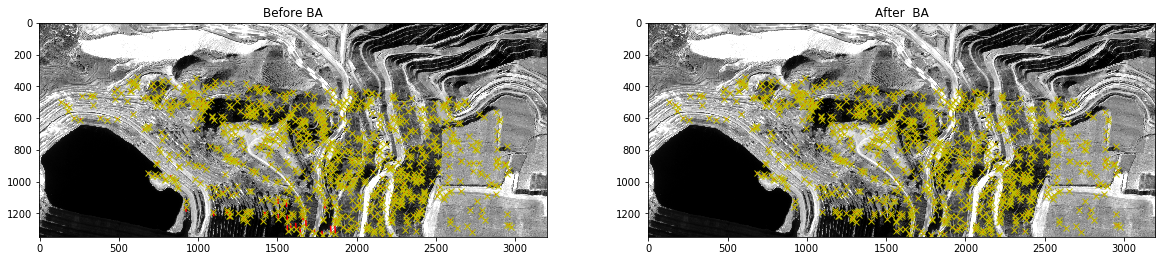

In [400]:
# warning: this is slow...

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Before BA')
ax2.title.set_text('After  BA')
ax1.imshow((mycrops[im_idx]['crop']), cmap="gray")
ax2.imshow((mycrops[im_idx]['crop']), cmap="gray")
for k in range(1000):
    # before bundle adjustment
    ax1.plot([pts_gt[k,0], pts_reproj_before[k,0] ], [pts_gt[k,1], pts_reproj_before[k,1]], 'r-')
    ax1.plot(*pts_gt[k], 'yx')
    # after bundle adjustment
    ax2.plot([pts_gt[k,0], pts_reproj_after[k,0] ], [pts_gt[k,1], pts_reproj_after[k,1]], 'r-')
    ax2.plot(*pts_gt[k], 'yx')
plt.show()

### Check the distance between the projection rays of two cameras

This gives an idea of the error in the traingulation of points before and after Bundle Adjustment.

Checking the distance between projection rays...
...done!



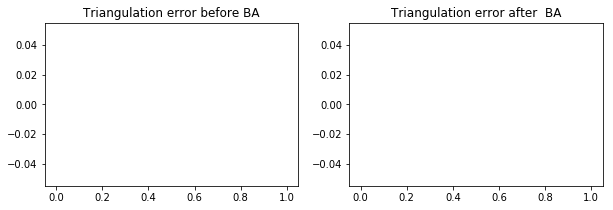

In [401]:
from PIL import Image

print('Checking the distance between projection rays...')

im1, im2 = 0,1

# get SIFT keypoints visible in both images
visible_idx = np.logical_and(~np.isnan(C[im1*2,:]), ~np.isnan(C[im2*2,:])) 
pts1, pts2 = C[(im1*2):(im1*2+2), visible_idx], C[(im2*2):(im2*2+2), visible_idx]
tr_err, tr_err_ba = [],[]
pts_3d_sift, pts_3d_sift_ba = np.zeros((pts1.shape[1], 3)), np.zeros((pts1.shape[1], 3))

triangulate_err_hist = True 
triangulate_err_dsm  = False

# triangulate and compute triangulation error (i.e. distance between projection rays)
for n in range(pts1.shape[1]):
    pt1, pt2 = pts1[:,n].ravel(), pts2[:,n].ravel()
    # before bundle adjustment
    pts_3d_sift[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop[im1], P_crop[im2])
    tr_err.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop[im1], P_crop[im2]))
    # after bundle adjustment
    pts_3d_sift_ba[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2])
    tr_err_ba.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2]))

if triangulate_err_hist:
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.title.set_text('Triangulation error before BA')
    ax2.title.set_text('Triangulation error after  BA')
    ax1.hist(tr_err, bins=40); 
    ax2.hist(tr_err_ba, bins=40);
    
# project dsm of the cloud but instead of projecting the height, project the triangulation error
if triangulate_err_dsm:
    # before bundle adjustment
    x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}.tif'.format(im1,im2))
    # after bundle adjustment
    x , y, z = pts_3d_sift_ba[:,0], pts_3d_sift_ba[:,1], pts_3d_sift_ba[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err_ba)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}_ba.tif'.format(im1,im2))
    
print('...done!\n')

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [402]:
print('Writing point clouds of SIFT keypoints...')

if not os.path.isdir(input_dir+'/sift_clouds_before'):
    os.mkdir(input_dir+'/sift_clouds_before')
if not os.path.isdir(input_dir+'/sift_clouds_after'):
    os.mkdir(input_dir+'/sift_clouds_after')

# pairs with extremly short baselines are not well posed for depth from stereo so we filter them
pairs_to_match = []
for i in range(n_cam):
    for j in range(i+1,n_cam):
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
        _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
        if np.linalg.norm(optical_center2 - optical_center1) > 150000 :
            pairs_to_match.append([i,j])  
    
    
for [im1,im2] in pairs_to_match:
        
    # get SIFT keypoints visible in both images
    visible_idx = np.logical_and(~np.isnan(C[im1*2,:]), ~np.isnan(C[im2*2,:])) 
    pts1, pts2 = C[(im1*2):(im1*2+2), visible_idx], C[(im2*2):(im2*2+2), visible_idx]

    # triangulation of SIFT keypoints before bundle adjustment
    pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop[im1], P_crop[im2])
    x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, h)).T
    fn = input_dir+'/sift_clouds_before/{:02}_{:02}.ply'.format(im1, im2)
    ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))

    # triangulation of SIFT keypoints after bundle adjustment
    pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop_ba[im1], P_crop_ba[im2])
    x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, h)).T
    fn = input_dir+'/sift_clouds_after/{:02}_{:02}_ba.ply'.format(im1, im2)
    ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))
        
print('...done!\n')

Writing point clouds of SIFT keypoints...
...done!



### Recover the corrected RPCs from the corrected projection matrices

In [403]:
#fit rpc

import rpc_fit
import copy

if not os.path.isdir(input_dir+'/rpc_adj'):
    os.mkdir(input_dir+'/rpc_adj')

# rpc fitting starts here
myrpcs_calib = []
for im_idx in range(n_cam):

    rpc_init = copy.copy(myrpcs2[im_idx])
    
    # calibrate and get error
    input_P, input_im, input_ecef = P_crop_ba[im_idx], mycrops[im_idx]['crop'], pts_3d_ba
    rpc_calib, err_calib = fit_rpc.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_rpc_adj.txt'
    rpc_calibrated.write(input_dir+'/rpc_adj/'+rpc_calib_fn)
    
    myrpcs_calib.append(rpc_calib)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred, _ = rpc_calib.inverse_estimate(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

image 0, RMSE calibrated RPC = 8.278679936279811e-05
image 1, RMSE calibrated RPC = 3.5005593651010885e-05
image 2, RMSE calibrated RPC = 2.9285399581019272e-05
image 3, RMSE calibrated RPC = 3.146165204756959e-05
image 4, RMSE calibrated RPC = 5.211365992832242e-05
image 5, RMSE calibrated RPC = 3.7799663772706154e-05


Verify that the reprojection of 3d points with the RPC is closer than 0.0001 to the reprojection given by the corrected projection matrix.

In [404]:
# check that the calibrated RPCs are OK

for im_idx in range(int(C.shape[0]/2)):
    for p_idx in range(C.shape[1]):
        if not np.isnan(C[2*im_idx,p_idx]):
            p_2d_gt = C[(im_idx*2):(im_idx*2+2),p_idx]
            current_p = pts_3d_ba[p_idx,:]
            lat, lon, alt = ba_utils.ecef_to_latlon_custom(current_p[0], current_p[1], current_p[2])
            proj = P_crop[im_idx] @ np.expand_dims(np.hstack((current_p, np.ones(1))), axis=1)
            p_2d_proj = (proj[0:2,:] / proj[-1,-1]).ravel()
            col, row, alt = myrpcs2[im_idx].inverse_estimate(lon, lat, alt)
            p_2d_proj_rpc = np.hstack([col - mycrops[im_idx]['x0'], row - mycrops[im_idx]['y0']]).ravel()
            proj = P_crop_ba[im_idx] @ np.expand_dims(np.hstack((current_p, np.ones(1))), axis=1)
            p_2d_proj_ba = (proj[0:2,:] / proj[-1,-1]).ravel()
            col, row, alt = myrpcs_calib[im_idx].inverse_estimate(lon, lat, alt)
            p_2d_proj_rpc_ba = np.hstack([col, row])

            reprojection_error_P = np.sum(abs(p_2d_proj_ba - p_2d_gt))
            reprojection_error_RPC = np.sum(abs(p_2d_proj_rpc_ba - p_2d_gt))

            if abs(reprojection_error_RPC - reprojection_error_P) > 0.001:
                print('cam {}, point {}'.format(im_idx, p_idx))
                print('GT            : {:.4f} , {:.4f}'.format(p_2d_gt[0], p_2d_gt[1]))
                print('RPC proj      : {:.4f} , {:.4f}'.format(p_2d_proj_rpc[0], p_2d_proj_rpc[1]))
                print('P proj        : {:.4f} , {:.4f}'.format(p_2d_proj[0], p_2d_proj[1]))
                print('P proj   (BA) : {:.4f} , {:.4f}'.format(p_2d_proj_ba[0], p_2d_proj_ba[1]))
                print('RPC proj (BA) : {:.4f} , {:.4f}'.format(p_2d_proj_rpc_ba[0], p_2d_proj_rpc_ba[1]))

    print('Finished checking image {}'.format(im_idx))

Finished checking image 0
Finished checking image 1
Finished checking image 2
Finished checking image 3
Finished checking image 4
Finished checking image 5
